In [1]:
import os
import sys
cwd = os.getcwd()
source_path = os.path.join(cwd, '..')
print(source_path)
sys.path.append(source_path)

import logging
logging.getLogger('numba').setLevel(logging.WARNING)
logging.getLogger('matplotlib').setLevel(logging.WARNING)

import numpy as np
import dask.array as da
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

from src import Data, Parameters, Pycro, DownloadData, SimpleCellposeSegmentaion, BIGFISH_SpotDetection, CellProperties, Save_Images, Save_Masks, Save_Outputs, Save_Parameters, remove_local_data, return_to_NAS, save_copy


c:\Users\formanj\GitHub\AngelFISH\Notebooks\..


DEBUG:h5py._conv:Creating converter from 7 to 5
DEBUG:h5py._conv:Creating converter from 5 to 7
DEBUG:h5py._conv:Creating converter from 7 to 5
DEBUG:h5py._conv:Creating converter from 5 to 7


In [2]:
import zarr

zarr_path = r"C:\Users\formanj\GitHub\AngelFISH\Notebooks\DEFAULT_NAME_1"
zarr_dataset = zarr.open(zarr_path, mode='r')
print(zarr_dataset.tree())

PathNotFoundError: nothing found at path ''

In [ ]:
# Assuming the zarr_dataset contains arrays named 'images' and 'masks'
first_image = zarr_dataset['images'][0, 0, 0]  # adjust indexing if needed
first_mask = zarr_dataset['nuc_masks'][0, 0]    # adjust indexing if needed

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(first_image[0], cmap='gray')  # show first channel if multi-channel
axs[0].set_title('First Image')
axs[1].imshow(first_mask, cmap='gray')
axs[1].set_title('First Mask')
plt.show()

In [3]:
params = Parameters()
data = Data('DEFAULT_NAME')

params.num_chunks_to_run = 2

In [4]:
params.load_in_mask = True
params.local_dataset_location =  [os.path.join(os.getcwd(), '..', r'dataBases\JF001_0min_5uM_12')]
params.initial_data_location = None
params.independent_params = {}

if data.images is None:
    DownloadData().main(**params.__dict__)
    output = Pycro().main(**params.__dict__)
    data.images = output['images']
    data.independent_params = output['independent_params']
    data.position_indexs = output['position_indexs']

pp = data.images.shape[0]
tt = data.images.shape[1]
cc = data.images.shape[2]
zz = data.images.shape[3]
yy = data.images.shape[4]
xx = data.images.shape[5]

print(data)

Dataset opened                
Data(zarr_path=DEFAULT_NAME, loaded=True, dataset_keys=['_zarr_path', '_ds', '_loaded', 'images', 'independent_params', 'position_indexs'])


INFO:cellpose.models:>> nuclei << model set to be used


Segmenting Nuclei


INFO:cellpose.core:** TORCH CUDA version installed and working. **
INFO:cellpose.core:>>>> using GPU (CUDA)
INFO:cellpose.models:>>>> loading model C:\Users\formanj\.cellpose\models\nucleitorch_0
c:\Users\formanj\GitHub\AngelFISH\.venv\Lib\site-packages\cellpose\resnet_torch.py:271: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` 

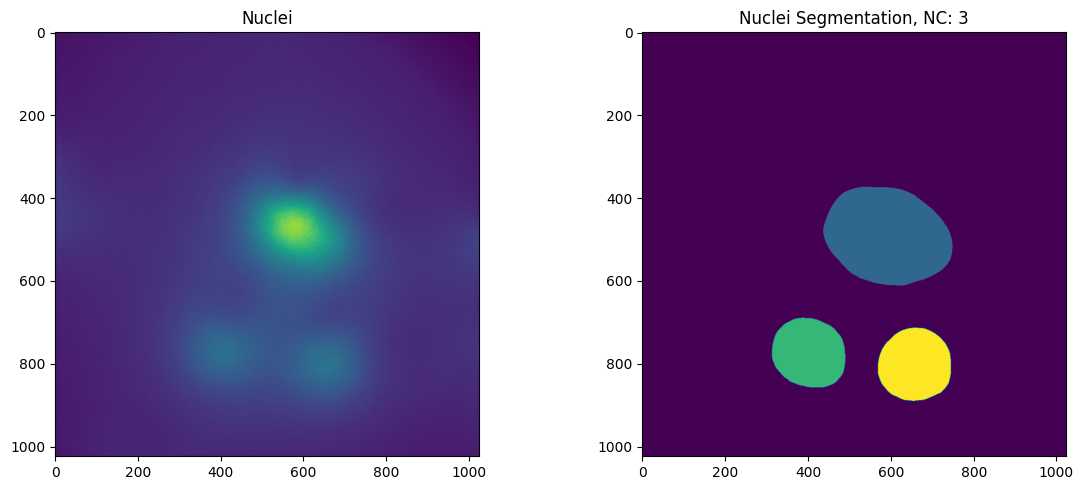

INFO:cellpose.models:>> nuclei << model set to be used
INFO:cellpose.core:** TORCH CUDA version installed and working. **
INFO:cellpose.core:>>>> using GPU (CUDA)
INFO:cellpose.models:>>>> loading model C:\Users\formanj\.cellpose\models\nucleitorch_0
INFO:cellpose.models:>>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
INFO:cellpose.core:** TORCH CUDA version installed and working. **
INFO:cellpose.core:>>>> using GPU (CUDA)
INFO:cellpose.models:>> cyto3 << model set to be used


Segmenting Nuclei


INFO:cellpose.models:>>>> loading model C:\Users\formanj\.cellpose\models\cyto3
INFO:cellpose.models:>>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
INFO:cellpose.models:channels set to [0, 0]
INFO:cellpose.models:~~~ FINDING MASKS ~~~
INFO:cellpose.models:>>>> TOTAL TIME 0.58 sec


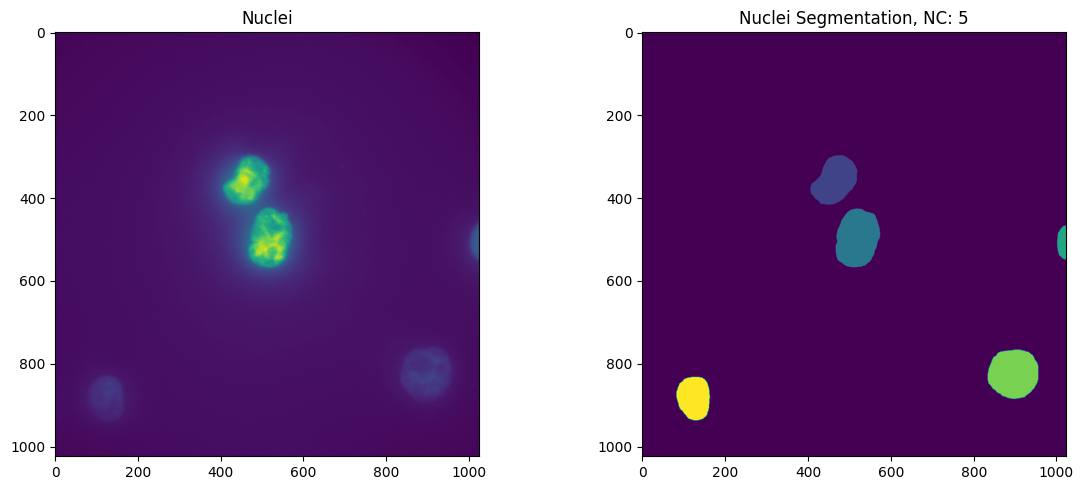

In [5]:
data.nuc_masks = np.zeros([pp, tt, yy, xx])
params.nucChannel = 2

count = 0
for p in range(pp):
    for t in range(tt):
        if count >= params.num_chunks_to_run:
            break
        kwargs = {**params.__dict__, **data.__dict__}
        kwargs['image'] = data.images[p, t]
        kwargs['fov'] = p
        kwargs['timepoint'] = t
        output = SimpleCellposeSegmentaion().main(**kwargs)
        data['nuc_masks', p, t] = output['nuc_mask']
        count += 1



In [6]:
import threading
import time
import numpy as np
import zarr

def monitor_array(path, interval=1.0):
    z = zarr.open(path, mode='r')
    while True:
        if np.all(z['nuc_masks'][0, 0] == 0):
            plt.imshow(z['nuc_masks'][0, 0], cmap='gray')
            plt.show()
            print("Detected zeroed data!")
            import pdb; pdb.set_trace()
        time.sleep(interval)

threading.Thread(target=monitor_array, args=(data._zarr_path,), daemon=True).start()

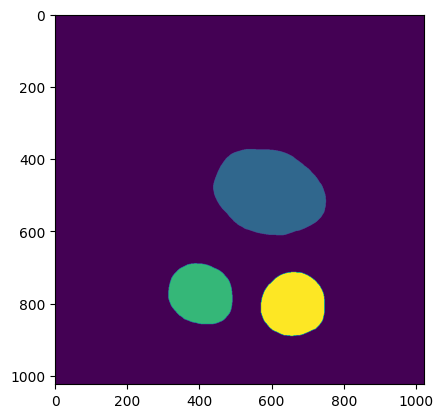

In [7]:
plt.imshow(data.nuc_masks[0, 0, :, :])
plt.show()

Detecting Spots


c:\Users\formanj\GitHub\AngelFISH\Notebooks\..\src\Steps\SpotDetection_Steps.py:323: RuntimeWarning: overflow encountered in scalar negative
  spot_background[:, edge_background_yx:-edge_background_yx, edge_background_yx:-edge_background_yx] = -1


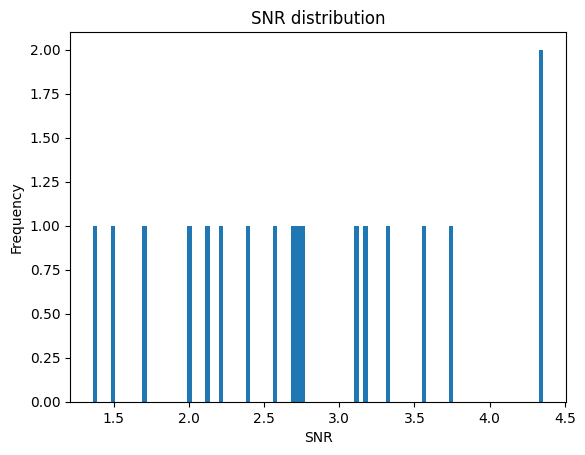

median SNR: 2.7112801320573263
mean SNR: 2.7608263154084876


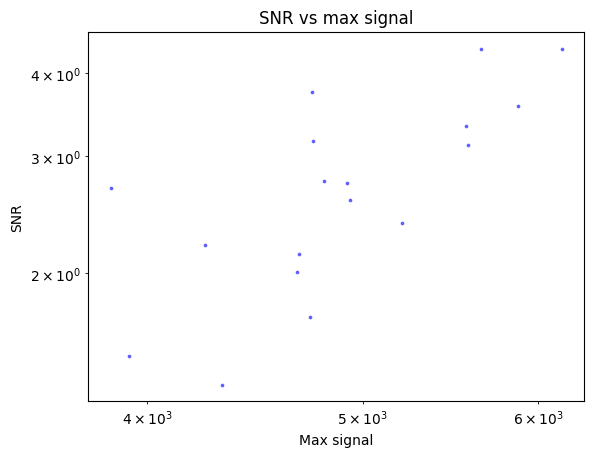

SNR threshold: None


c:\Users\formanj\GitHub\AngelFISH\.venv\Lib\site-packages\bigfish\detection\utils.py:321: UserWarning: Problem occurs during the computation of a reference spot. Not enough (uncropped) spots have been detected.
  warnings.warn("Problem occurs during the computation of a reference "


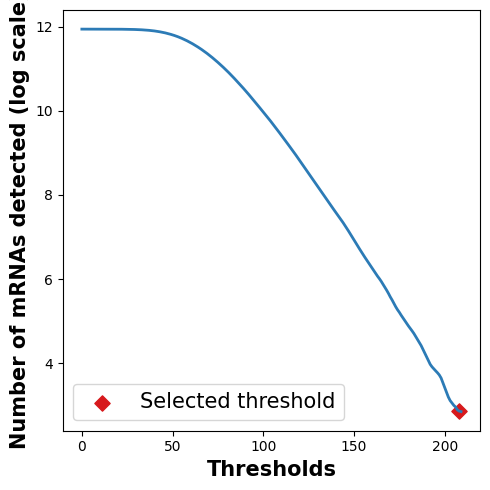

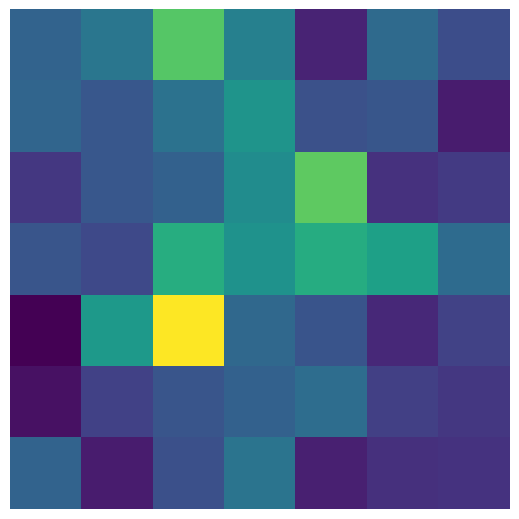

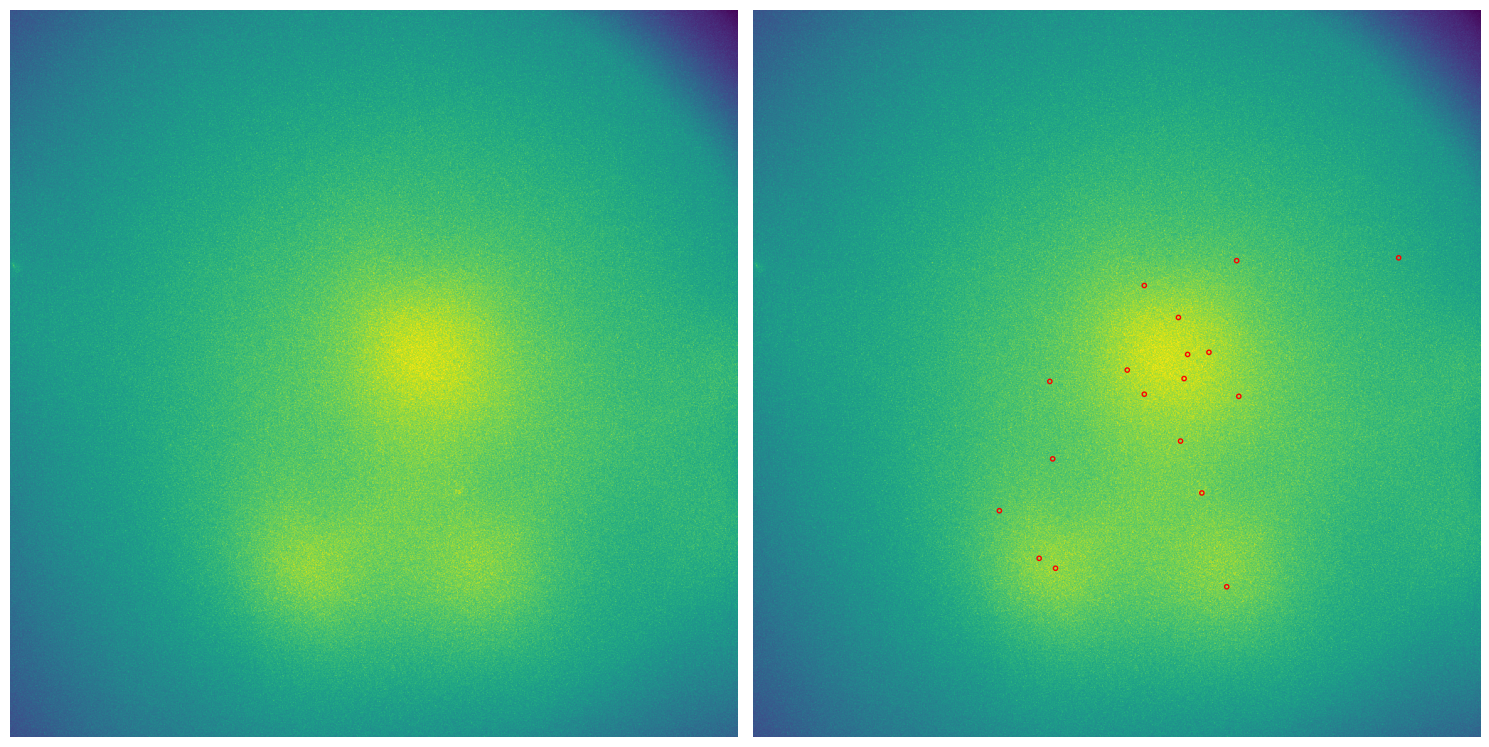

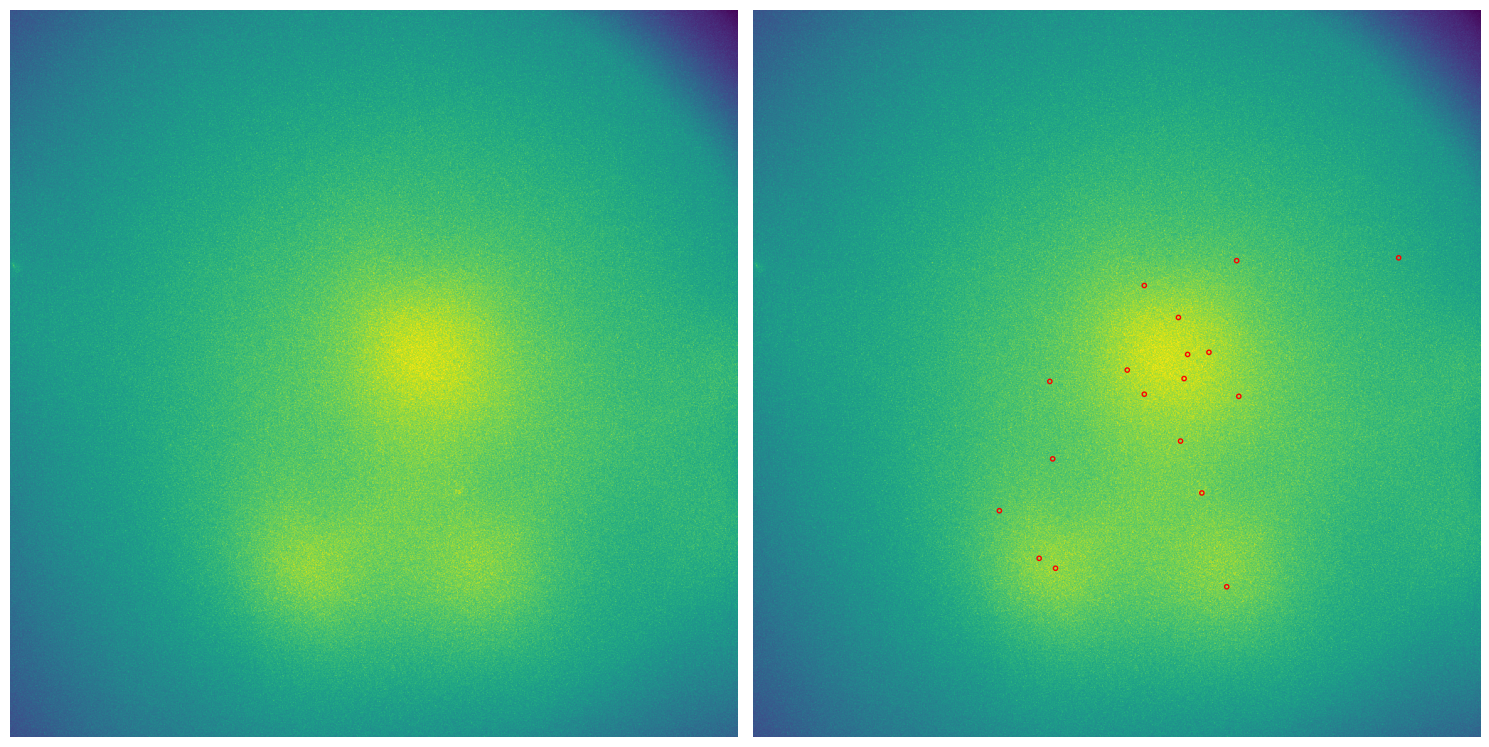

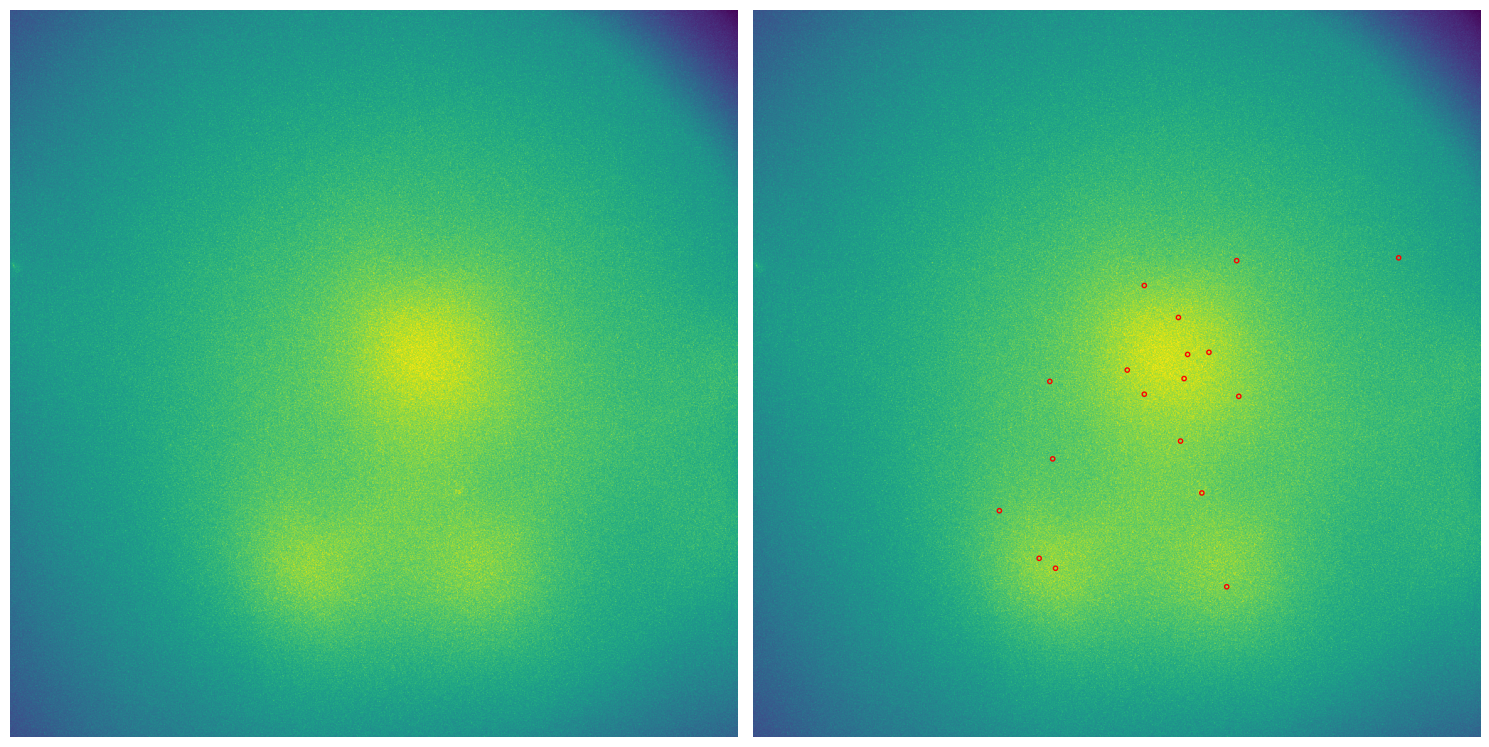

Extracting Cell Results from masks


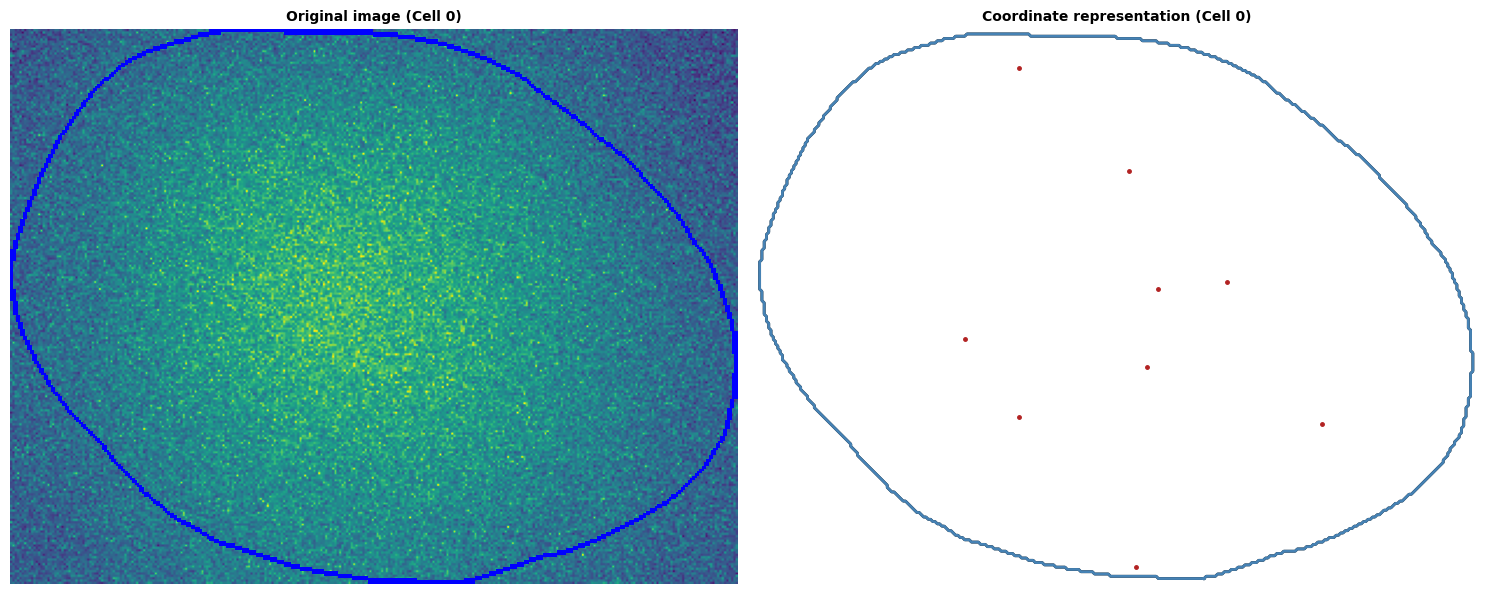

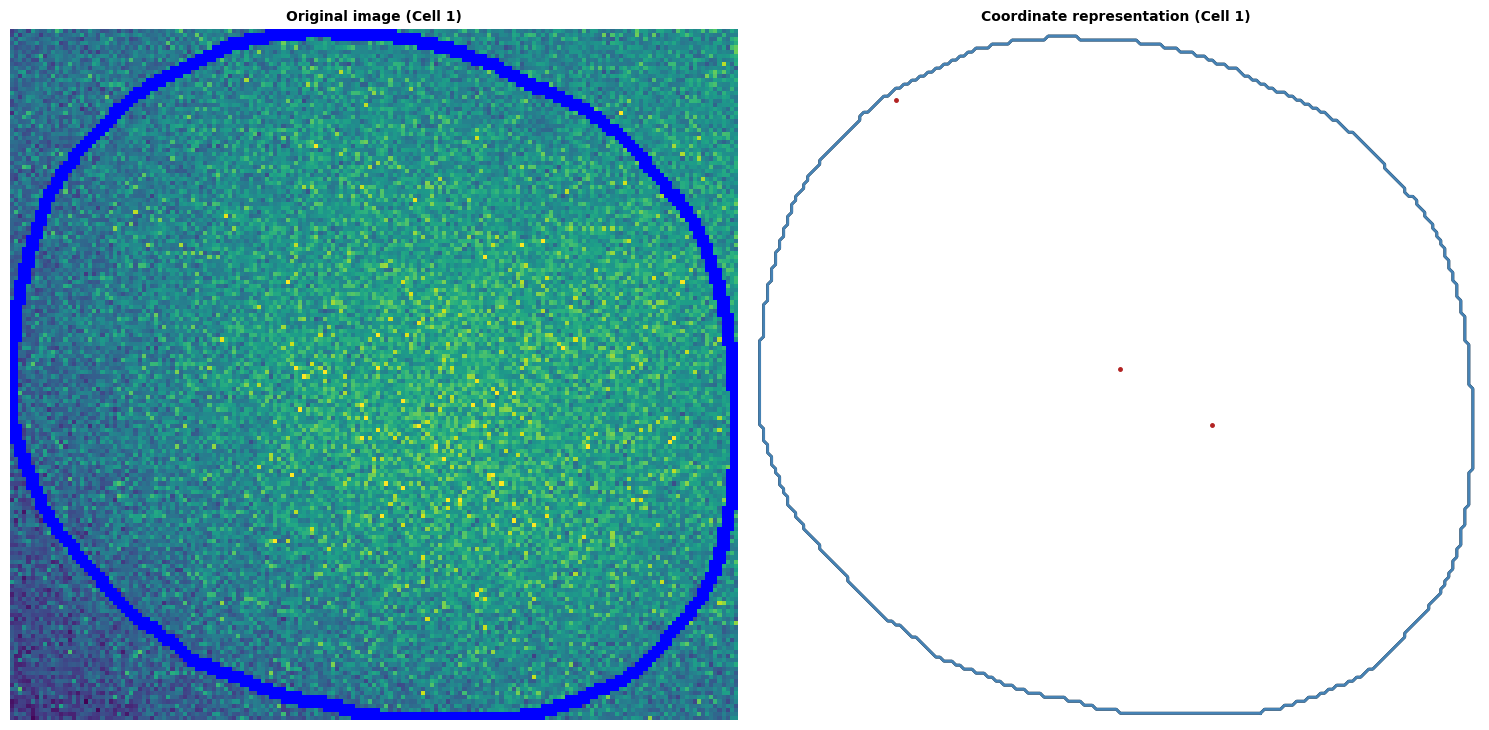

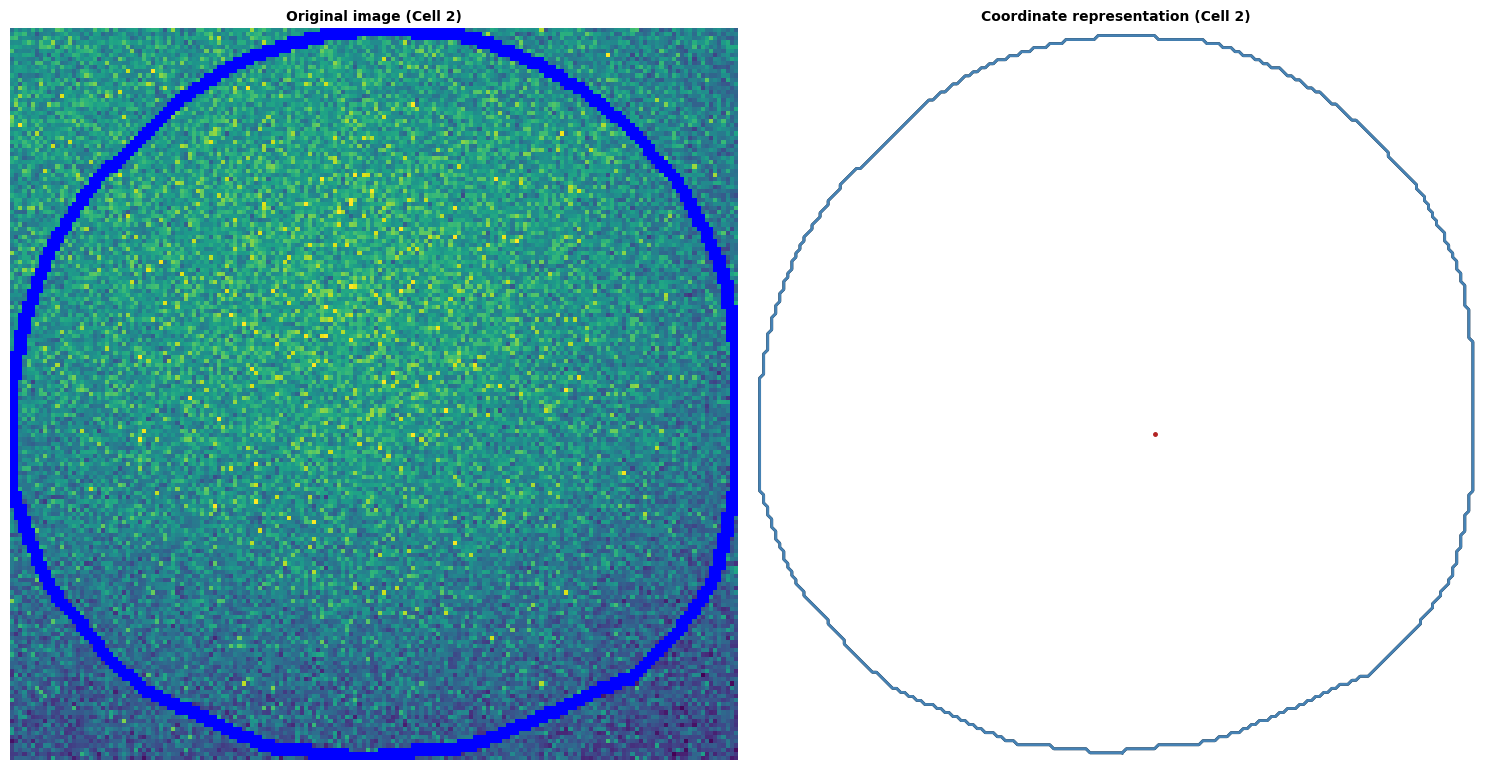

Computing Spot Properties
Standardizing Data
Complete Spot Detection


c:\Users\formanj\GitHub\AngelFISH\Notebooks\..\src\Steps\SpotDetection_Steps.py:323: RuntimeWarning: overflow encountered in scalar negative
  spot_background[:, edge_background_yx:-edge_background_yx, edge_background_yx:-edge_background_yx] = -1


Detecting Spots


c:\Users\formanj\GitHub\AngelFISH\Notebooks\..\src\Steps\SpotDetection_Steps.py:323: RuntimeWarning: overflow encountered in scalar negative
  spot_background[:, edge_background_yx:-edge_background_yx, edge_background_yx:-edge_background_yx] = -1


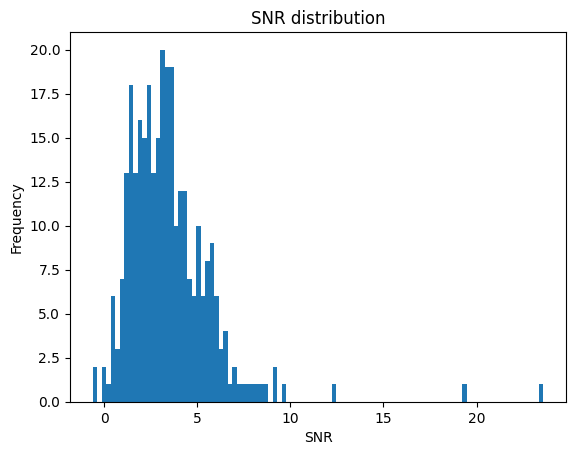

median SNR: 3.1669558655233816
mean SNR: 3.464559293488346


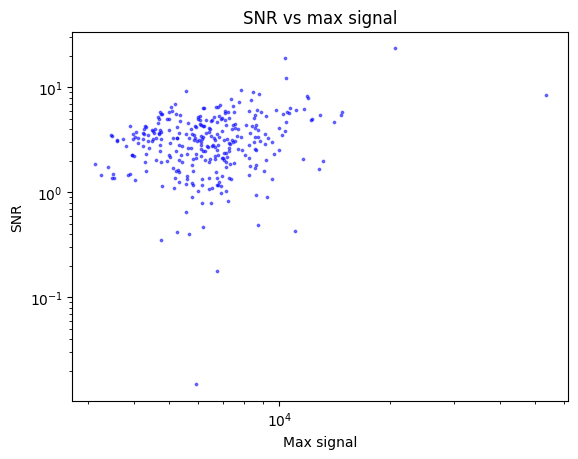

SNR threshold: None


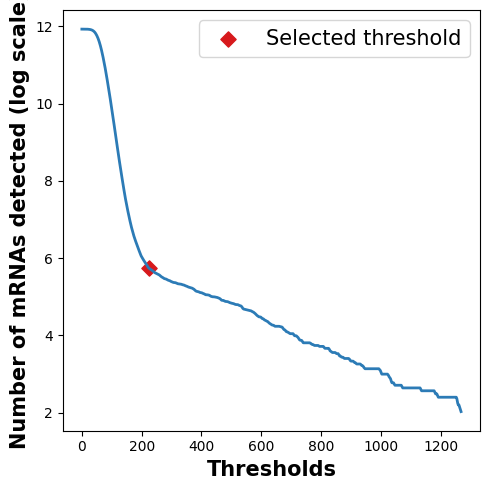

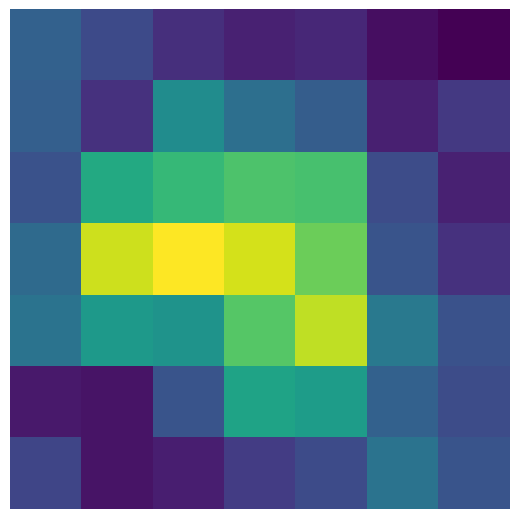

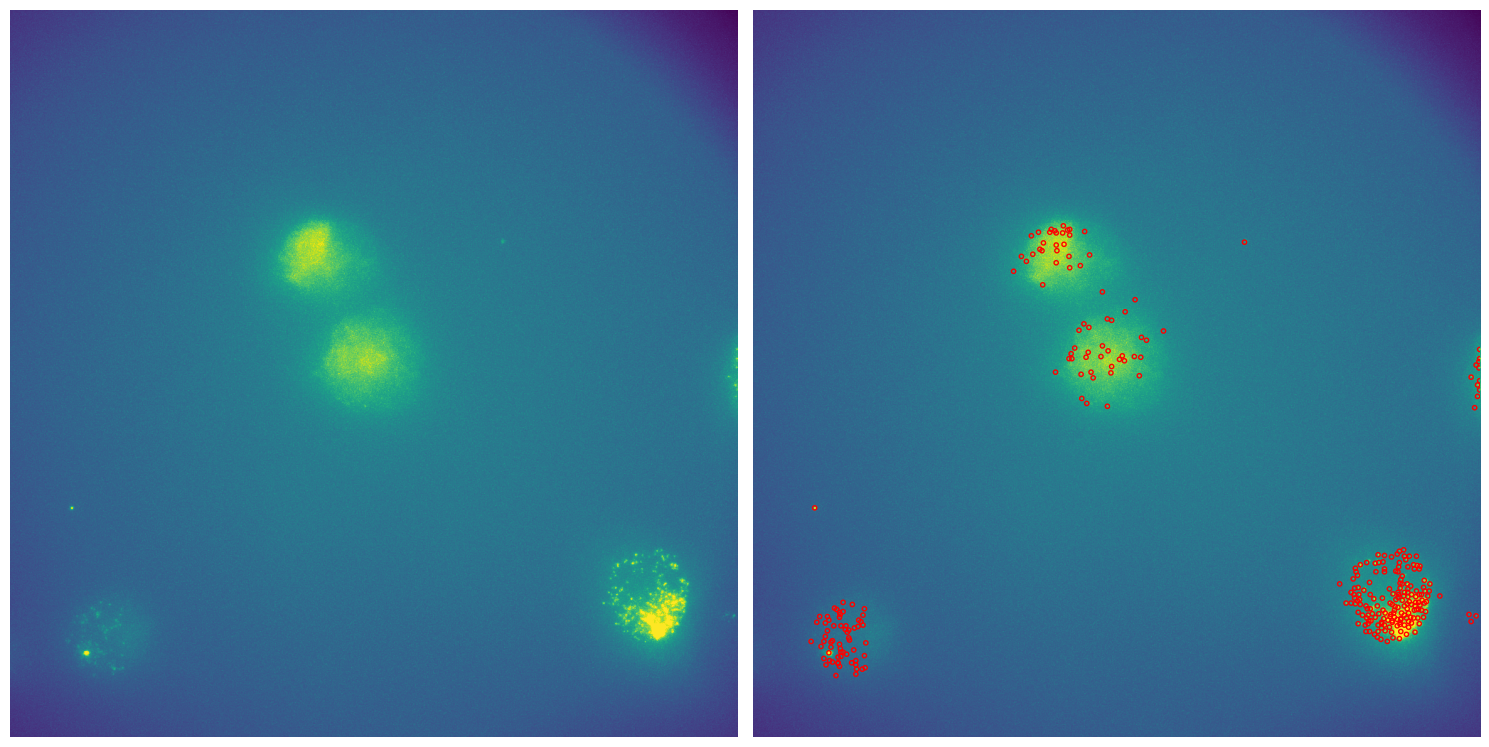

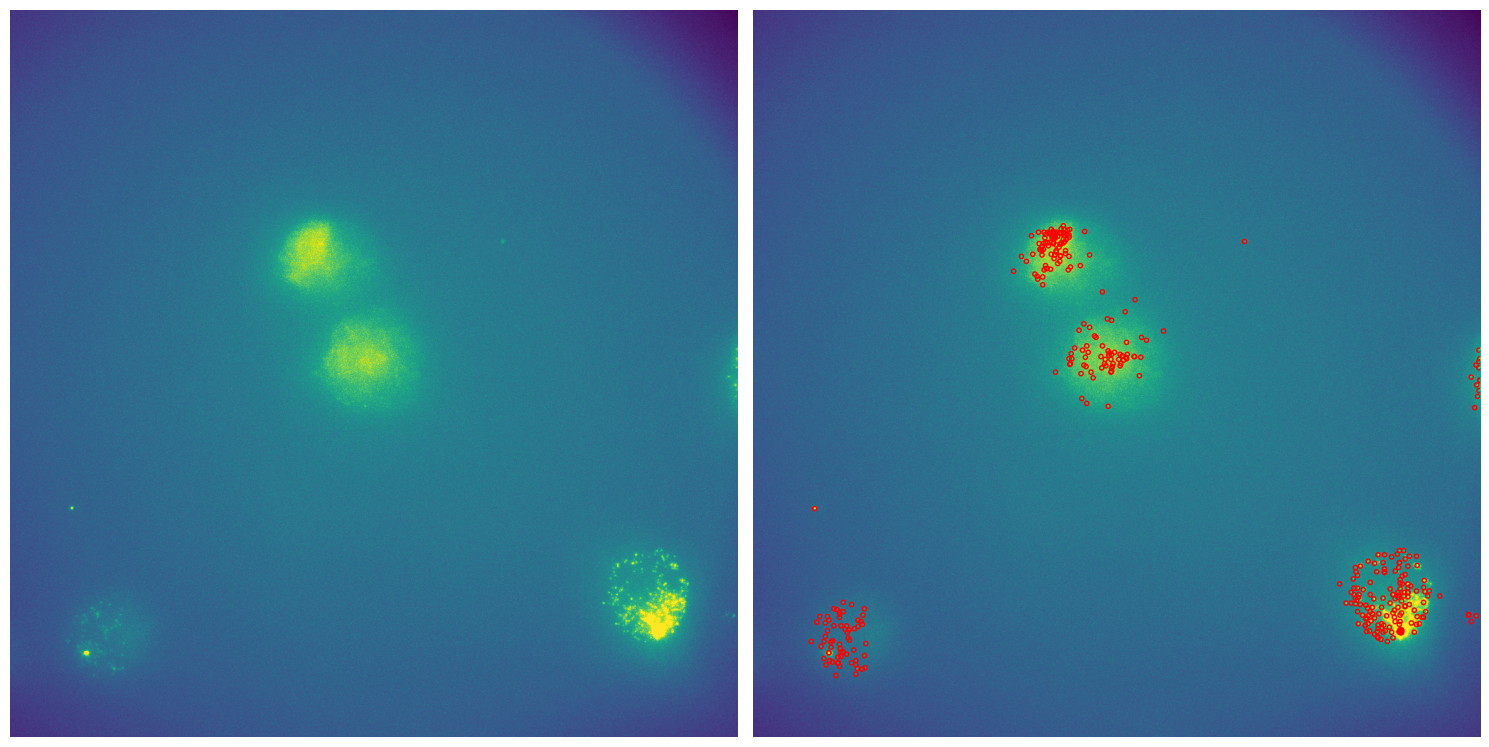

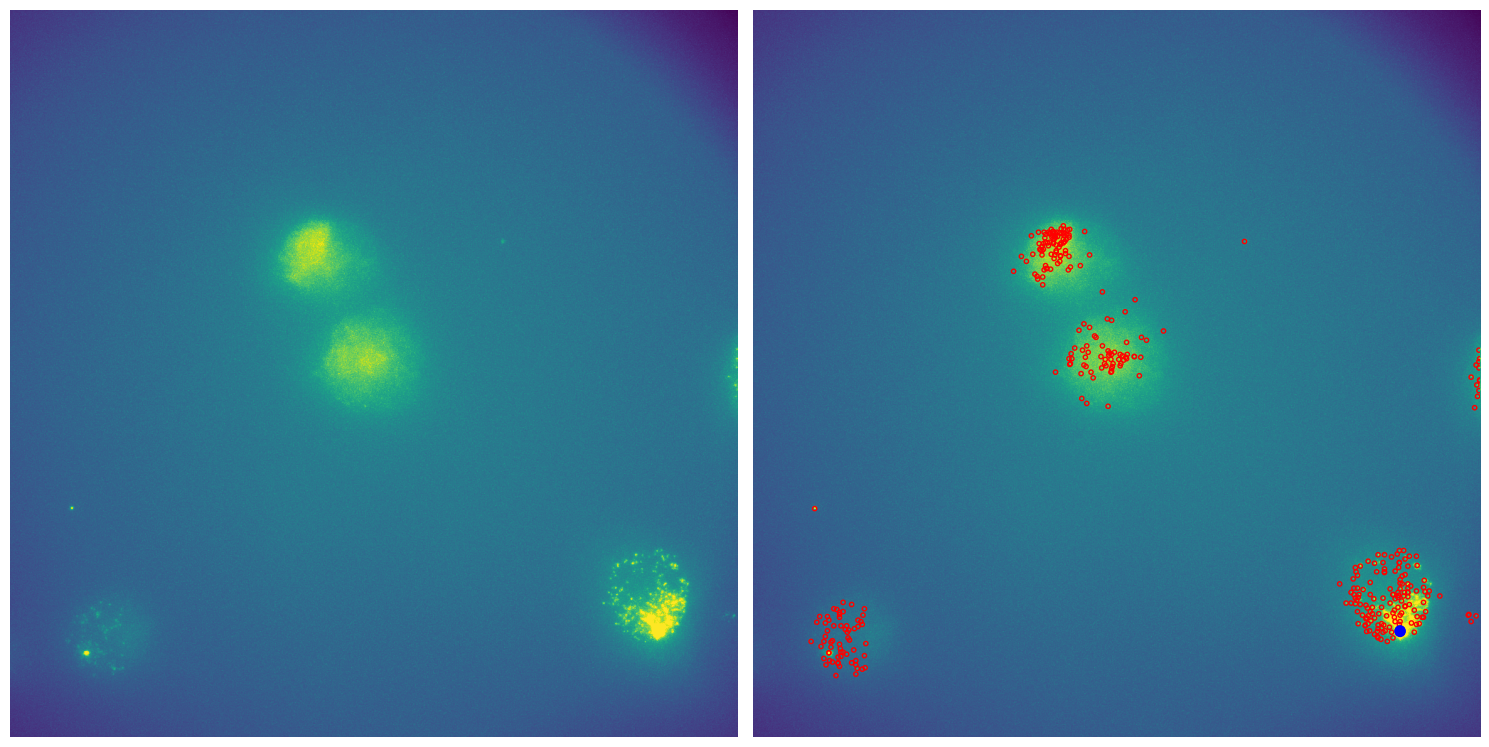

Extracting Cell Results from masks


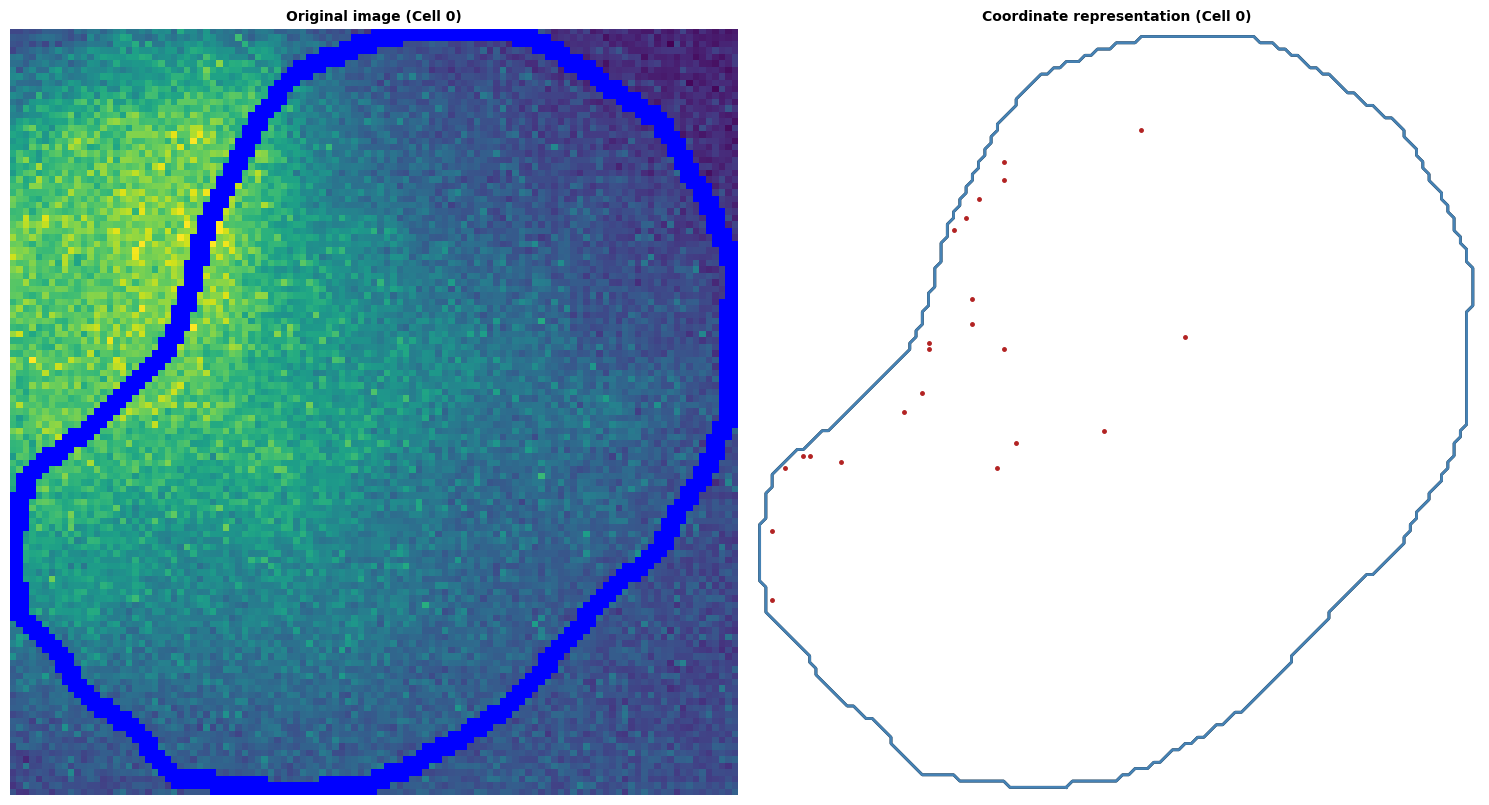

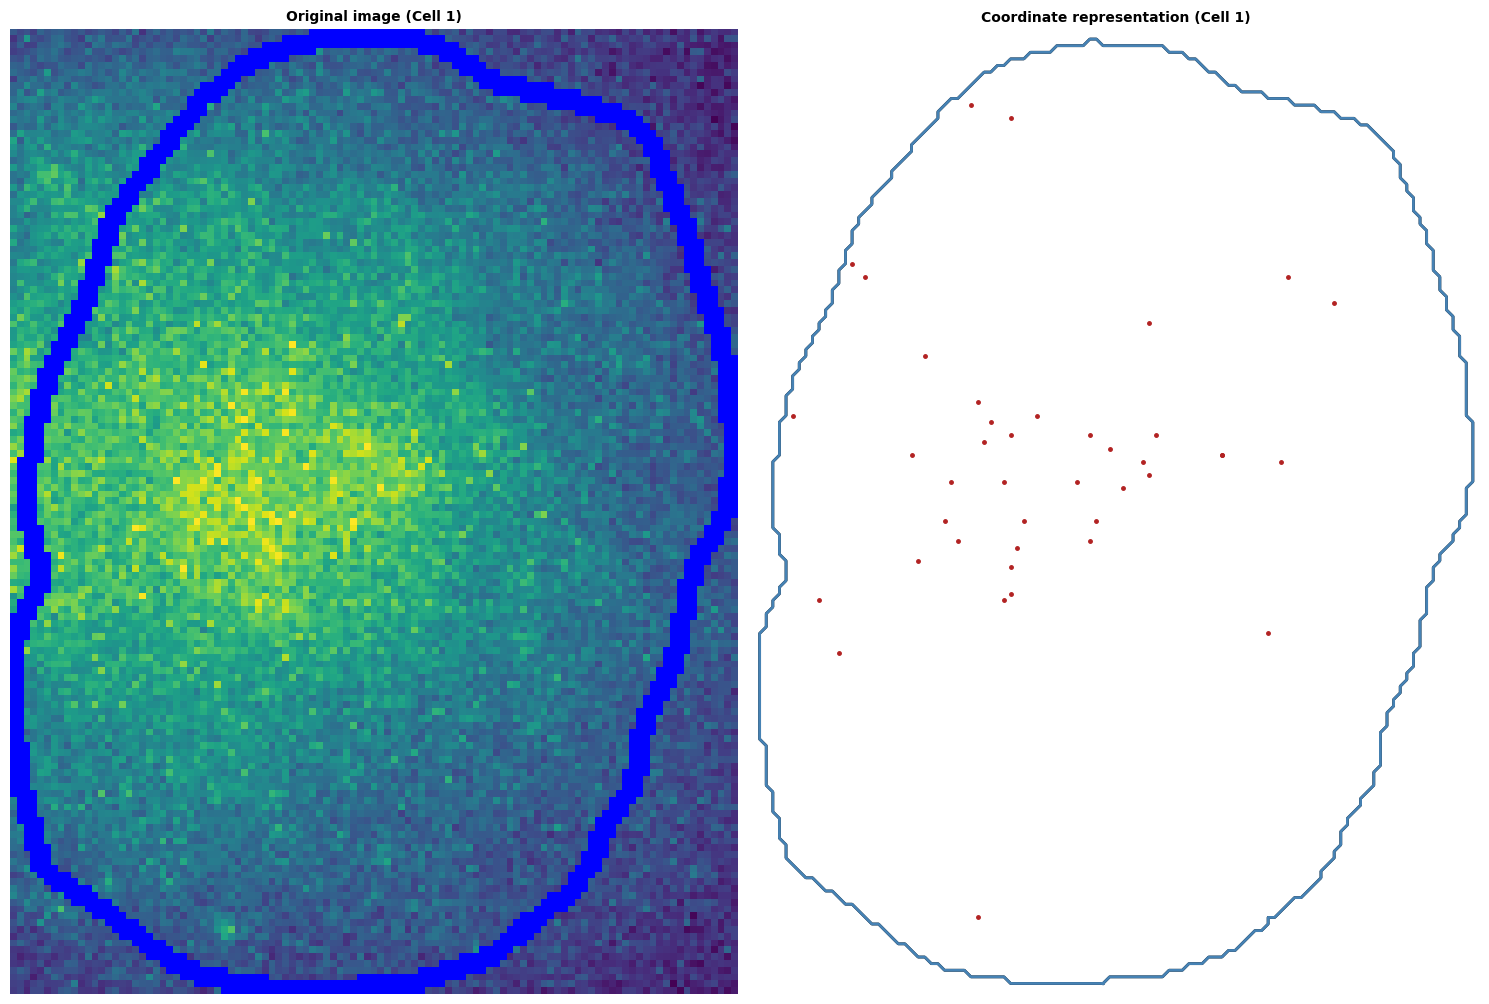

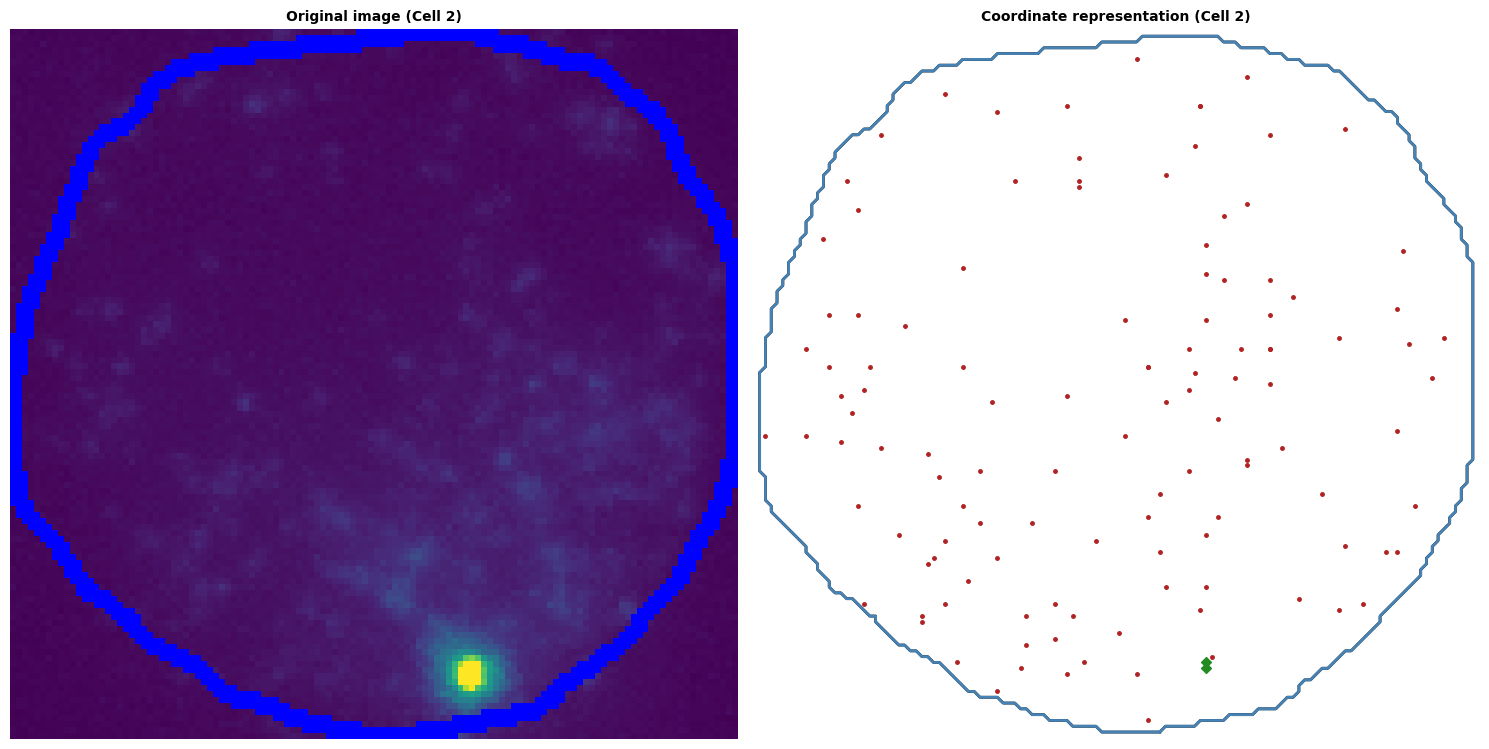

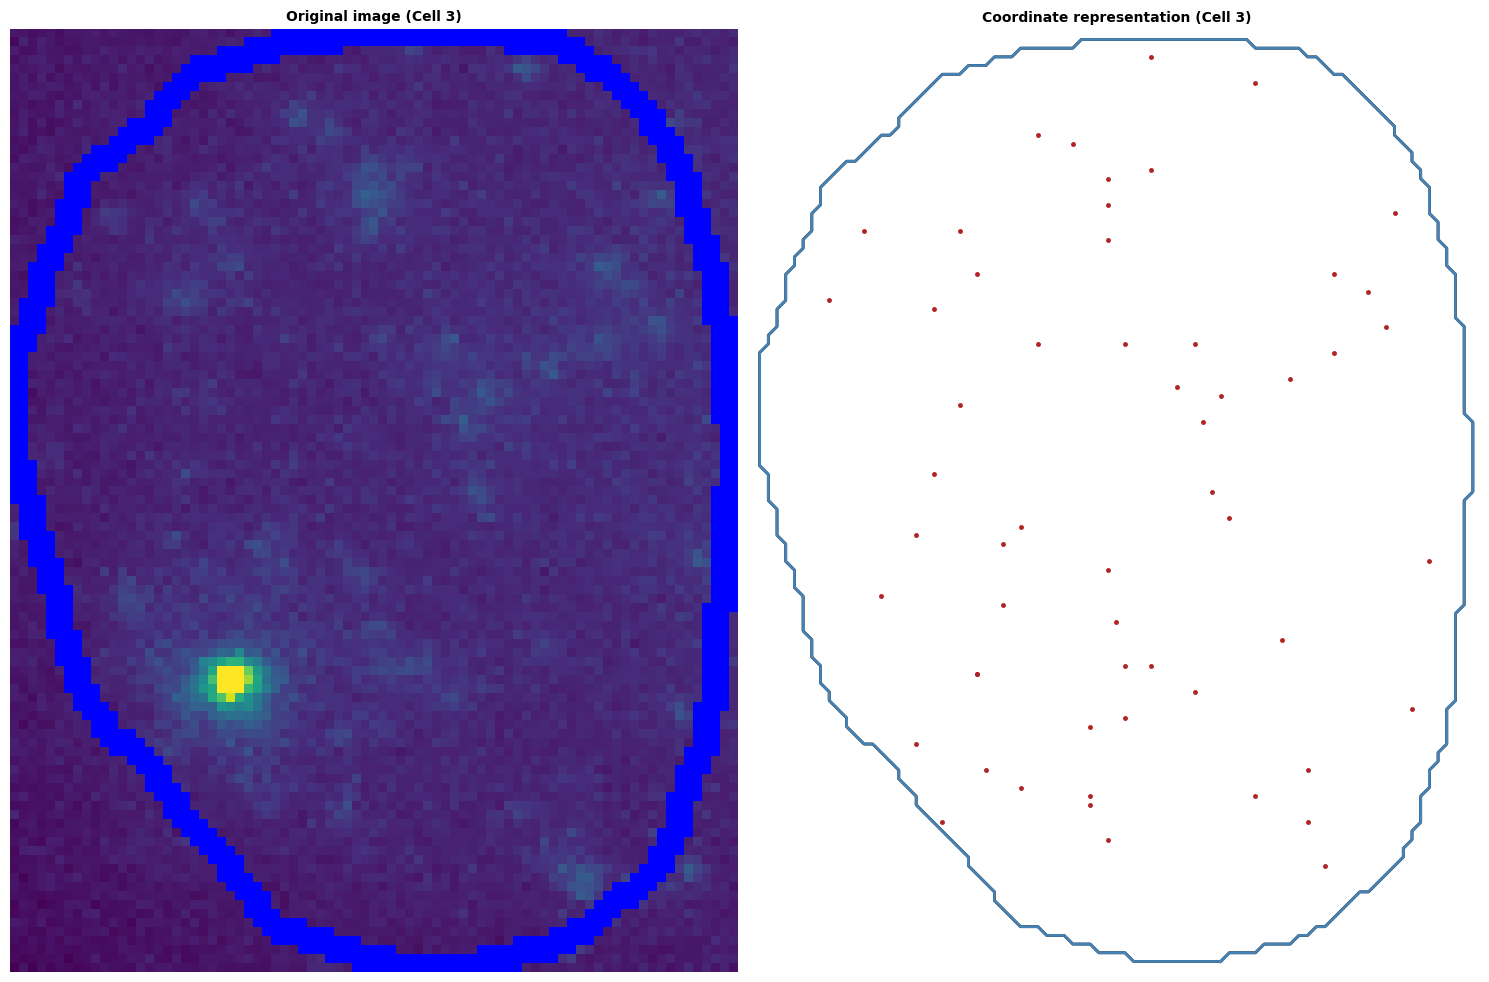

Computing Spot Properties
Standardizing Data
Complete Spot Detection


c:\Users\formanj\GitHub\AngelFISH\Notebooks\..\src\Steps\SpotDetection_Steps.py:323: RuntimeWarning: overflow encountered in scalar negative
  spot_background[:, edge_background_yx:-edge_background_yx, edge_background_yx:-edge_background_yx] = -1


In [8]:
params.FISHChannel = [0]
params.bigfish_alpha = 0.99
params.bigfish_beta = 1
params.bigfish_gamma = 5
params.voxel_size_yx = 130
params.voxel_size_z = 500
params.spot_yx = 160
params.spot_z = 1000

count = 0
for p in range(pp):
    for t in range(tt):
        if count >= params.num_chunks_to_run:
            break
        kwargs = {**params.__dict__, **data.__dict__}
        kwargs['image'] = data.images[p, t]
        if data.nuc_masks is not None:
            i = data.nuc_masks[p,t]
            kwargs['nuc_mask'] = np.array(i)
        if data.cell_masks is not None:
            i = data.cell_masks[p,t]
            kwargs['cell_mask'] = np.array(i)
        kwargs['fov'] = p
        kwargs['timepoint'] = t
        output = BIGFISH_SpotDetection().main(**kwargs)
        data.append(output)
        count += 1


In [9]:
count = 0
for p in range(pp):
    for t in range(tt):
        if count >= params.num_chunks_to_run:
            break
        kwargs = {**params.__dict__, **data.__dict__}
        kwargs['image'] = data.images[p, t]
        if data.nuc_masks is not None:
            kwargs['nuc_mask'] = data.nuc_masks[p, t]
            kwargs['nuc_mask'] = kwargs['nuc_mask'][np.newaxis, :, :]

        if data.cell_masks is not None:
            kwargs['cell_mask'] = data.cell_masks[p, t]
            kwargs['cell_mask'] = kwargs['cell_masks'][np.newaxis, :, :]
        kwargs['fov'] = p
        kwargs['timepoint'] = t
        output = CellProperties().main(**kwargs)
        data.append(output)
        count += 1

In [10]:
epsilon = 1e-6
# Initialize new columns with NaN
data.spotresults['MG_SNR'] = np.nan

# Map the nuclear and cytoplasmic properties to the spotresults DataFrame
# Map nuc_intensity_mean-0 and nuc_intensity_std-0 from cell_properties to spotresults
data.spotresults = data.spotresults.merge(
    data.cell_properties[['timepoint', 'fov', 'nuc_label', 'nuc_intensity_mean-0', 'nuc_intensity_std-0']],
    left_on=['timepoint', 'fov', 'cell_label'],
    right_on=['timepoint', 'fov', 'nuc_label'],
    how='left'
)

# Compute nuclear MG_SNR for nuclear spots.
nuc_mask = data.spotresults['is_nuc'] == 1
data.spotresults.loc[nuc_mask, 'MG_SNR'] = (
    data.spotresults.loc[nuc_mask, 'signal'] - data.spotresults.loc[nuc_mask, 'nuc_intensity_mean-0']
) / (data.spotresults.loc[nuc_mask, 'nuc_intensity_std-0'] + epsilon)

# # Compute cytoplasmic MG_SNR for cytoplasmic spots.
# cyto_mask = data.spotresults['is_nuc'] == 0
# data.spotresults.loc[cyto_mask, 'MG_SNR'] = (
#     data.spotresults.loc[cyto_mask, 'signal'] - data.spotresults.loc[cyto_mask, 'cyto_intensity_mean-0']
# ) / (data.spotresults.loc[cyto_mask, 'cyto_intensity_std-0'] + epsilon)

In [11]:
data.spotresults

z_px   y_px    x_px  cluster_index  is_nuc  cell_label  nuc_label_x  \
0     0.0  485.0   612.0           -1.0     1.0         1.0          1.0   
1     0.0  705.0   347.0           -1.0     1.0         2.0          2.0   
2    15.0  680.0   632.0           -1.0     0.0         0.0          0.0   
3    20.0  349.0   909.0           -1.0     0.0         0.0          0.0   
4    20.0  353.0   681.0           -1.0     0.0         0.0          0.0   
..    ...    ...     ...            ...     ...         ...          ...   
394  20.0  838.0   863.0           -1.0     1.0         4.0          4.0   
395  20.0  847.0   851.0           -1.0     1.0         4.0          4.0   
396  20.0  852.0  1007.0           -1.0     0.0         0.0          0.0   
397  20.0  853.0   892.0           -1.0     1.0         4.0          4.0   
398  20.0  882.0   879.0           -1.0     0.0         0.0          0.0   

          snr  signal  timepoint  fov  FISH_Channel    MG_SNR  nuc_label_y  \
0    1.359325  4323.0          0    0             0 -0.970946          1.0   
1    3.742171  4747.0          0    0             0  1.282621          2.0   
2    2.735964  4921.0          0    0             0       NaN          NaN   
3    2.686597  3852.0          0    0             0       NaN          NaN   
4    1.503135  3925.0          0    0             0       NaN          NaN   
..        ...     ...        ...  ...           ...       ...          ...   
394  7.171281  7263.0          0    1             0  0.390663          4.0   
395  5.207320  6014.0          0    1             0 -0.004833          4.0   
396  5.365175  4513.0          0    1             0       NaN          NaN   
397  1.539468  8498.0          0    1             0  0.781725          4.0   
398  4.170633  7058.0          0    1             0       NaN          NaN   

     nuc_intensity_mean-0  nuc_intensity_std-0  
0             4654.193044           341.103560  
1             4352.541395           307.541141  
2                     NaN                  NaN  
3                     NaN                  NaN  
4                     NaN                  NaN  
..                    ...                  ...  
394           6029.261623          3158.065430  
395           6029.261623          3158.065430  
396                   NaN                  NaN  
397           6029.261623          3158.065430  
398                   NaN                  NaN  

[399 rows x 16 columns]

In [12]:
mg_threshold = 1.5 
mg_counts = (
    data.spotresults[data.spotresults['MG_SNR'] > mg_threshold]
    .groupby(['timepoint', 'fov', 'cell_label'])
    .size()
    .reset_index(name='MG_nuc_counts')
)

data.cellresults = data.cellresults.merge(
    mg_counts,
    left_on=['timepoint', 'fov', 'cell_id'],
    right_on=['timepoint', 'fov', 'cell_label'],
    how='left'
)
data.cellresults['MG_nuc_counts'] = data.cellresults['MG_nuc_counts'].fillna(0).astype(int)

In [13]:
data.cellresults

cell_id  cell_area  nuc_area  nb_rna  nb_rna_in_nuc  nb_rna_out_nuc  \
0        1      57018     57018       9              9               0   
1        2      23916     23916       3              3               0   
2        3      24926     24926       1              1               0   
3        1       9266      9266      23             23               0   
4        2      11870     11870      41             41               0   
5        4      11658     11658     119            119               0   
6        5       6840      6840      57             57               0   

   nb_foci  nb_transcription_site  fov  timepoint  FISH_Channel  cell_label  \
0        0                      0    0          0             0         1.0   
1        0                      0    0          0             0         2.0   
2        0                      0    0          0             0         NaN   
3        0                      0    1          0             0         1.0   
4        0                      0    1          0             0         2.0   
5        0                      2    1          0             0         4.0   
6        0                      0    1          0             0         5.0   

   MG_nuc_counts  
0              5  
1              1  
2              0  
3             18  
4             31  
5             22  
6             22

In [ ]:
Save_Images().main(**{**params.__dict__, **data.__dict__})

Save_Masks().main(**{**params.__dict__, **data.__dict__, 
                    'masks':{'nuc_masks': data.nuc_masks}})

Save_Parameters().main(params, **{**params.__dict__, **data.__dict__})

Save_Outputs().main(data.__dict__, **{**params.__dict__, 'position_indexs': data.position_indexs})


: 

In [ ]:
return_to_NAS().main(**params.__dict__)

In [ ]:
print(params)
print(data)